# Backtesting an ML strategy with Backtrader

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

In [3]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [4]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Backtrader Setup

### Custom Commission Scheme

In [5]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

### DataFrame Loader

In [6]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [7]:
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Strategy

Includes an option to only trade on certain weekdays in lines 39/40.

In [8]:
class MLStrategy(bt.Strategy):
    params = (('n_positions', 10),
              ('min_positions', 5),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

### Create and Configure Cerebro Instance

In [9]:
cerebro = bt.Cerebro()  # create a "Cerebro" instance
cash = 10_000
# comminfo = FixedCommisionScheme()
# cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(cash)

### Add input data

In [10]:
idx = pd.IndexSlice
data = pd.read_hdf('00_data/backtest.h5', 'data').sort_index()
tickers = data.index.get_level_values(0).unique()

for ticker in tickers:
    df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)

### Run Strategy Backtest

In [11]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addstrategy(MLStrategy, n_positions=25, min_positions=20, 
                    verbose=True, log_file='bt_log.csv')
start = time()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f}')
print(f'Duration: {format_time(duration)}')

Final Portfolio Value: 9,571.66
Duration: 00:00:43


### Plot result

Disabled because large number of datafeeds all plot separately.

In [12]:
# cerebro.plot()  # plot the results
# figure = cerebro.plot(style='candlebars')[0][0]
# figure.savefig(f'backtrader.png')

### Get `pyfolio` inputs

In [12]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

returns.to_hdf('backtrader.h5', 'returns')
positions.to_hdf('backtrader.h5', 'positions')
transactions.to_hdf('backtrader.h5', 'transactions/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev')

## Run pyfolio analysis

In [13]:
returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')

In [77]:
benchmark = web.DataReader('SP500', 'fred', '2015', '2019').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC').filter(returns.index.get_level_values(0)).squeeze()

In [78]:
daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

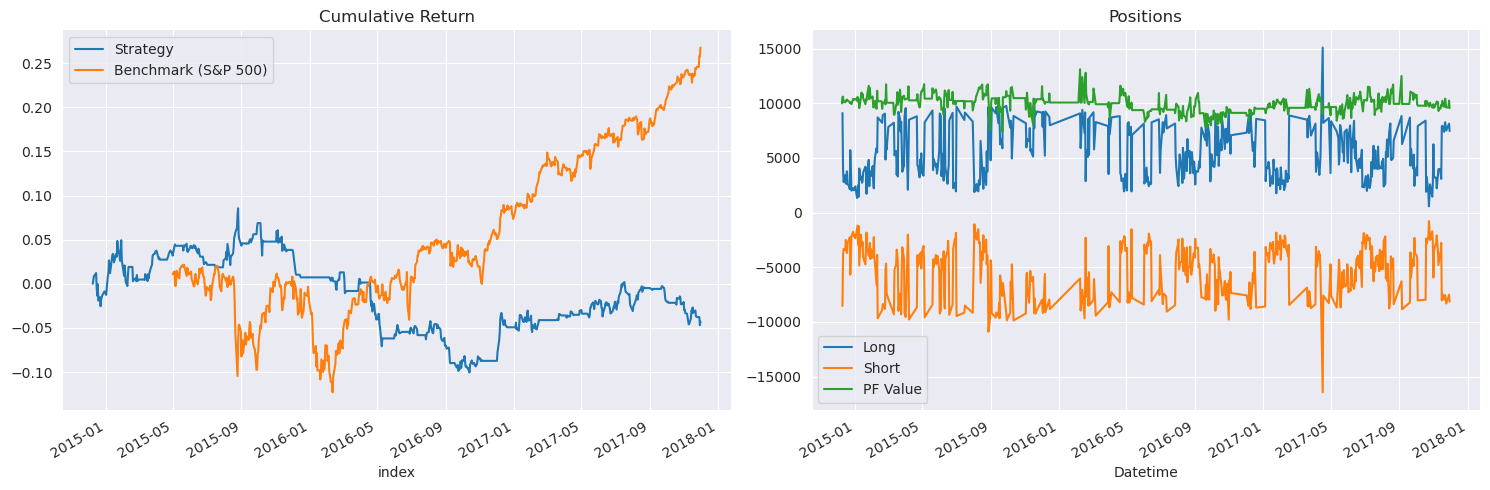

In [79]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy').join(benchmark.to_frame('Benchmark (S&P 500)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

Start date,2015-05-01
End date,2017-11-30
Total months,31
,Backtest
Annual return,-2.986%
Cumulative returns,-7.555%
Annual volatility,7.064%
Sharpe ratio,-0.39
Calmar ratio,-0.17
Stability,0.32
Max drawdown,-17.144%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.14,2015-08-26,2016-10-13,NaT,NaN
1,2.55,2015-05-26,2015-07-17,2015-08-19,62
2,0.66,2015-05-05,2015-05-20,2015-05-26,16
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
Fall2015,0.11%,-2.75%,1.34%
New Normal,-0.00%,-2.75%,2.14%


Top 10 long positions of all time,max
sid,
MYL,9.40%
HCA,9.00%
VRX,8.96%
BIDU,8.90%
BDX,8.70%
SRPT,8.55%
F,8.45%
TWTR,8.38%
NKE,8.37%


Top 10 short positions of all time,max
sid,
COP,-10.25%
AMD,-9.41%
HAL,-9.29%
TWTR,-9.17%
NFLX,-8.88%
SYF,-8.83%
APC,-8.70%
BMY,-8.68%
CRM,-8.67%


Top 10 positions of all time,max
sid,
COP,10.25%
AMD,9.41%
MYL,9.40%
HAL,9.29%
TWTR,9.17%
HCA,9.00%
VRX,8.96%
BIDU,8.90%
NFLX,8.88%


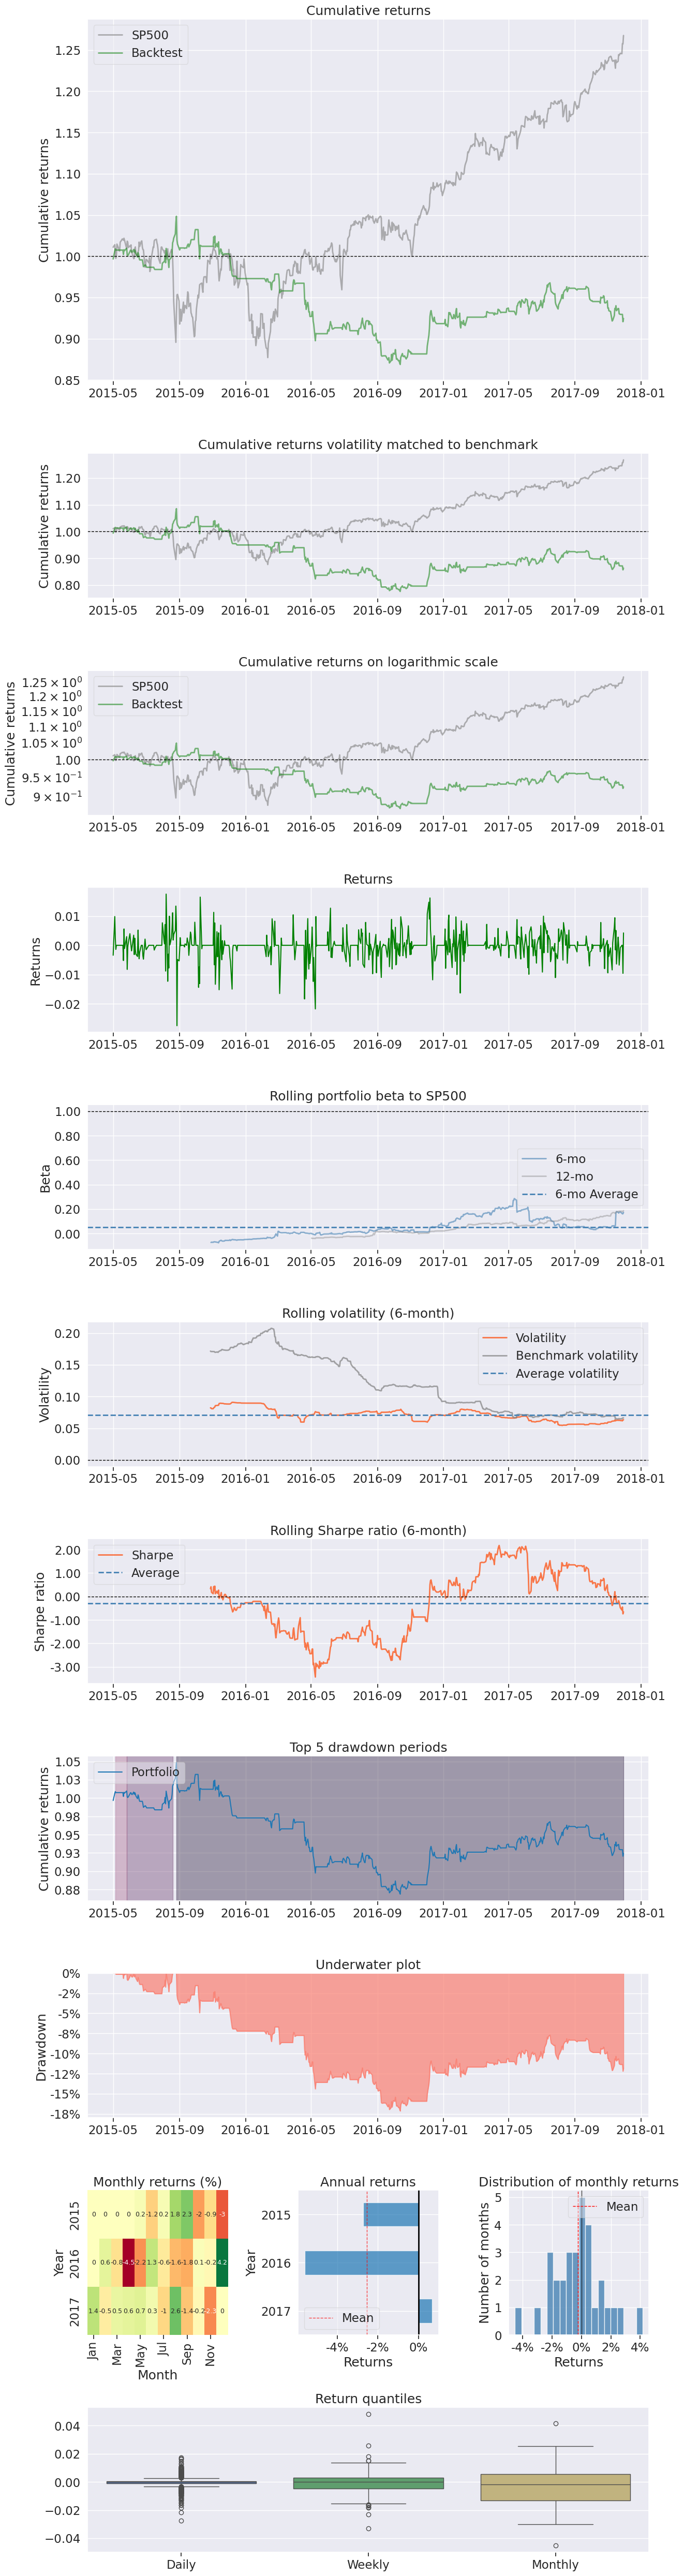

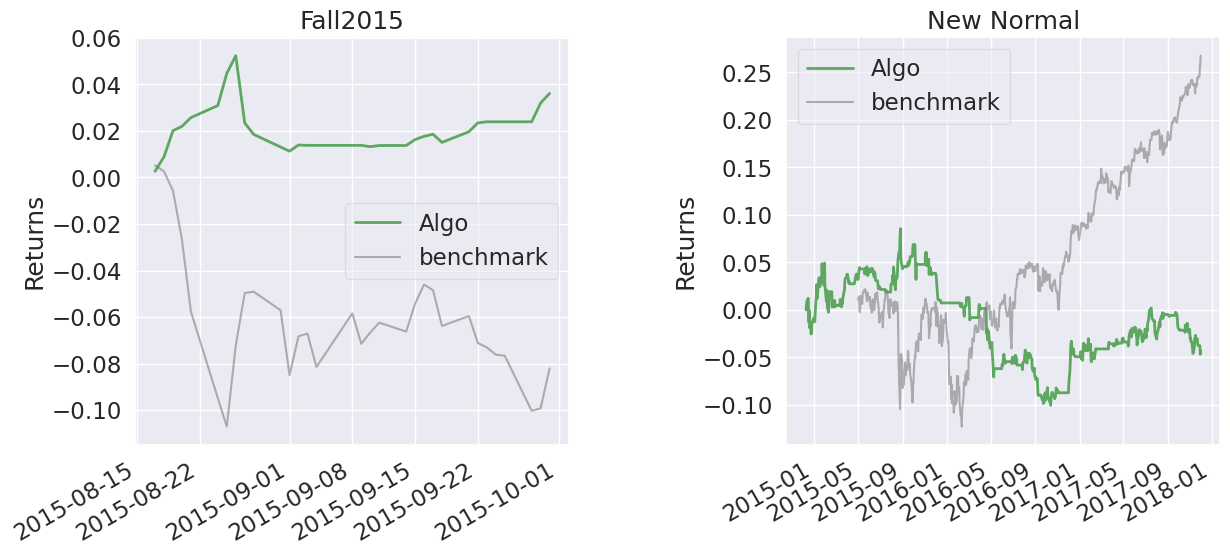

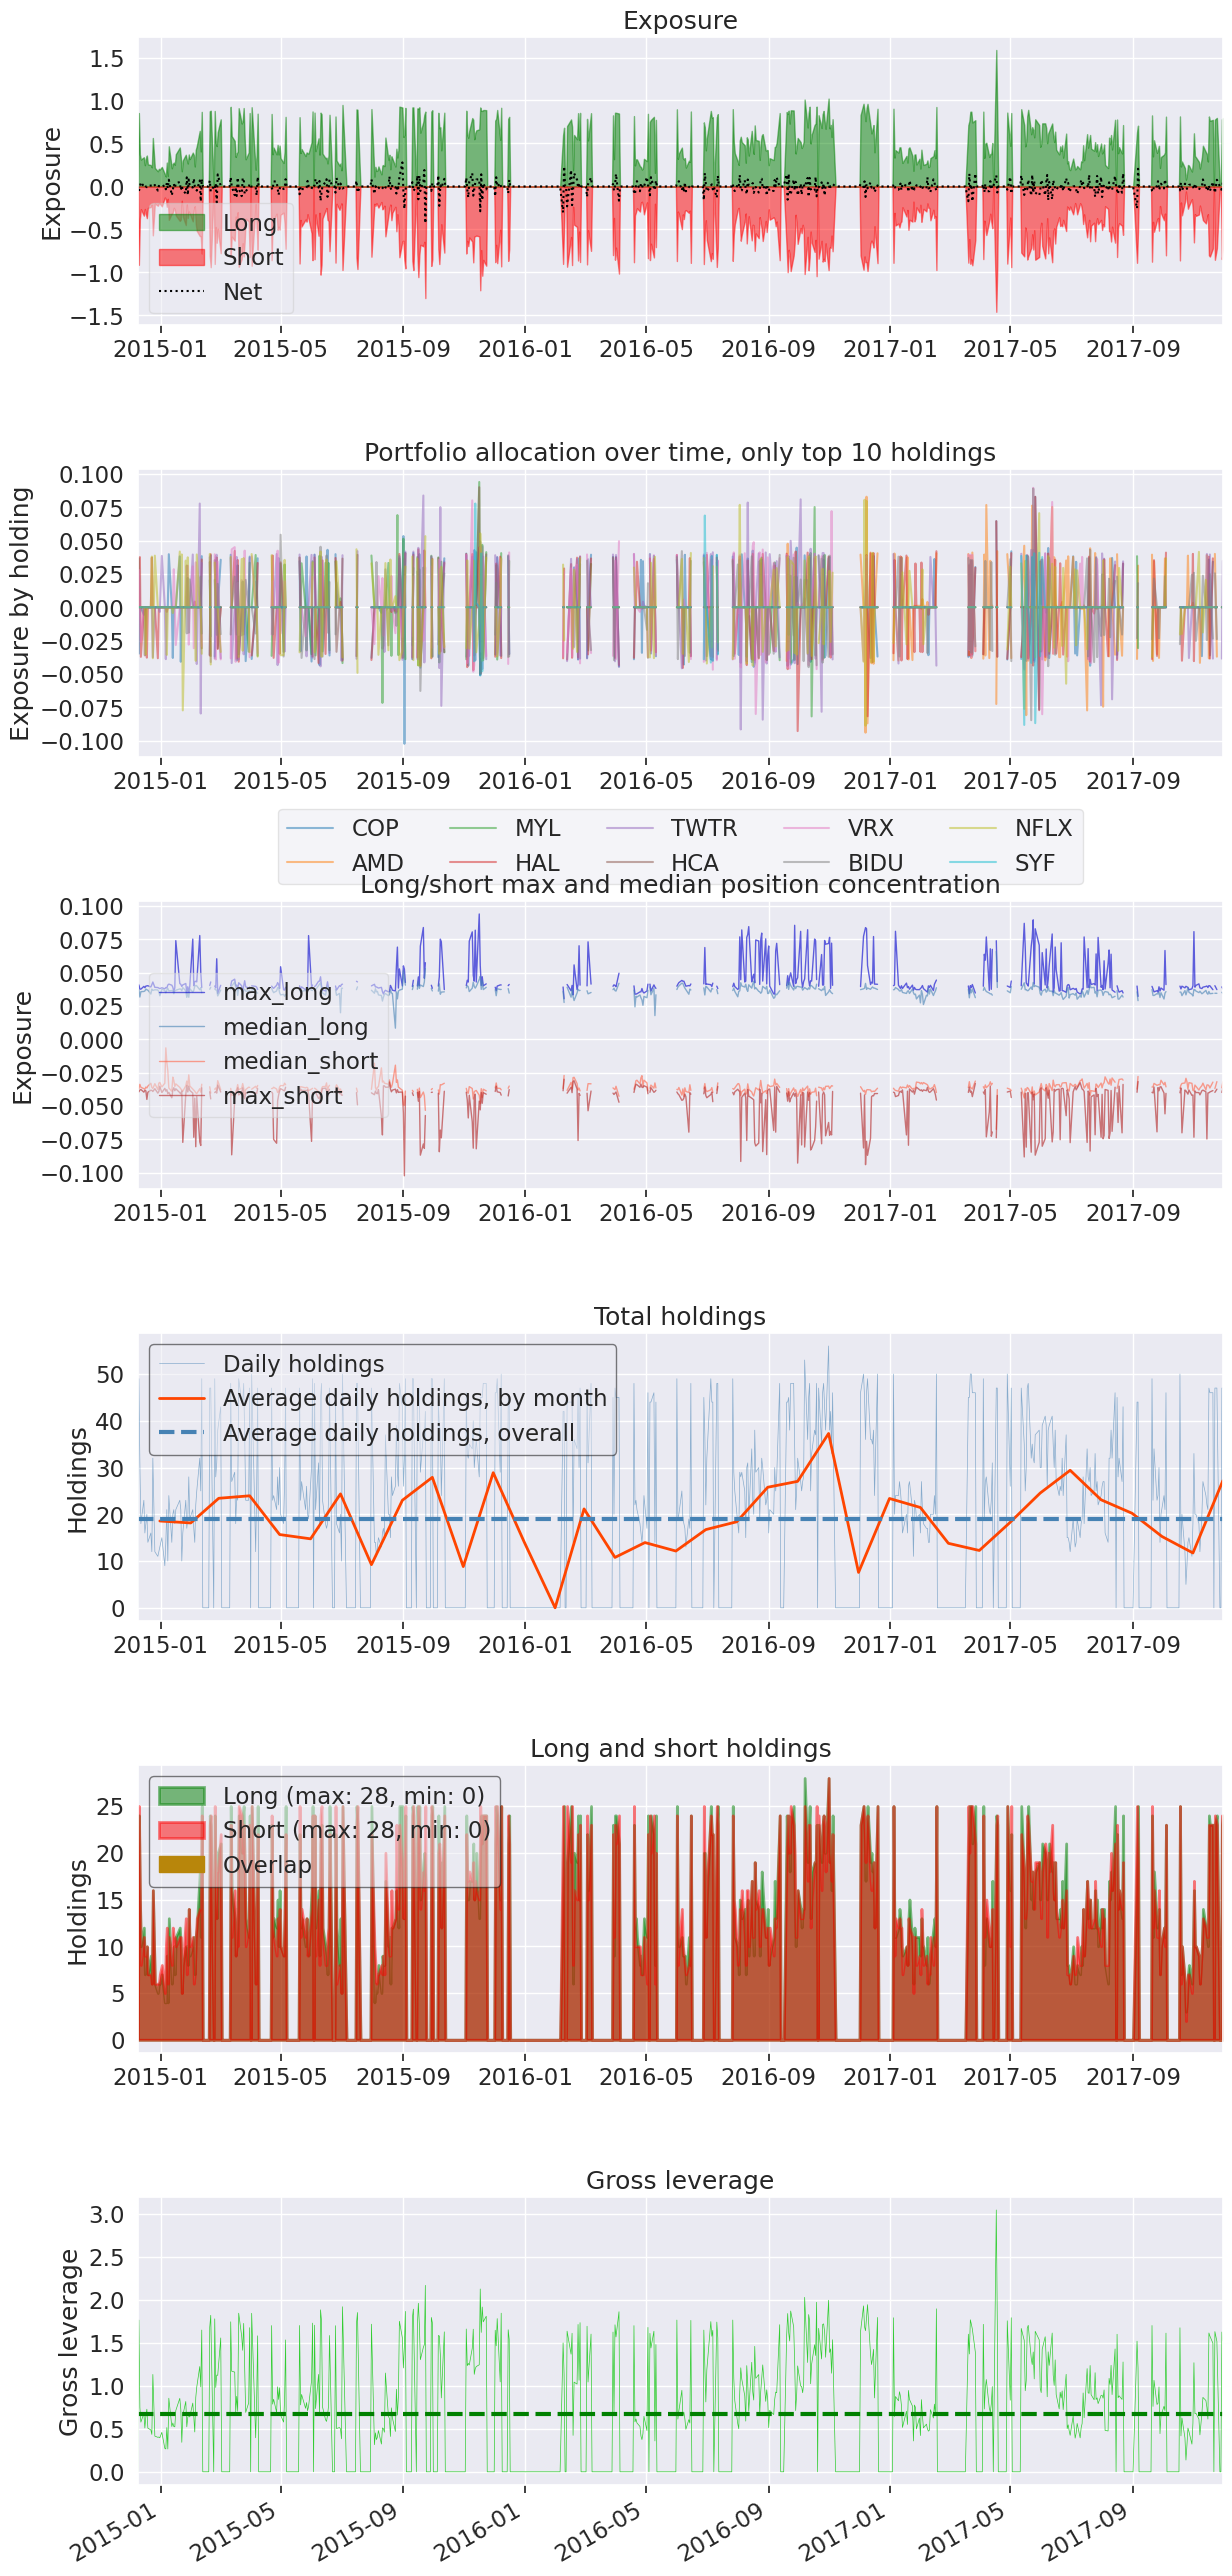

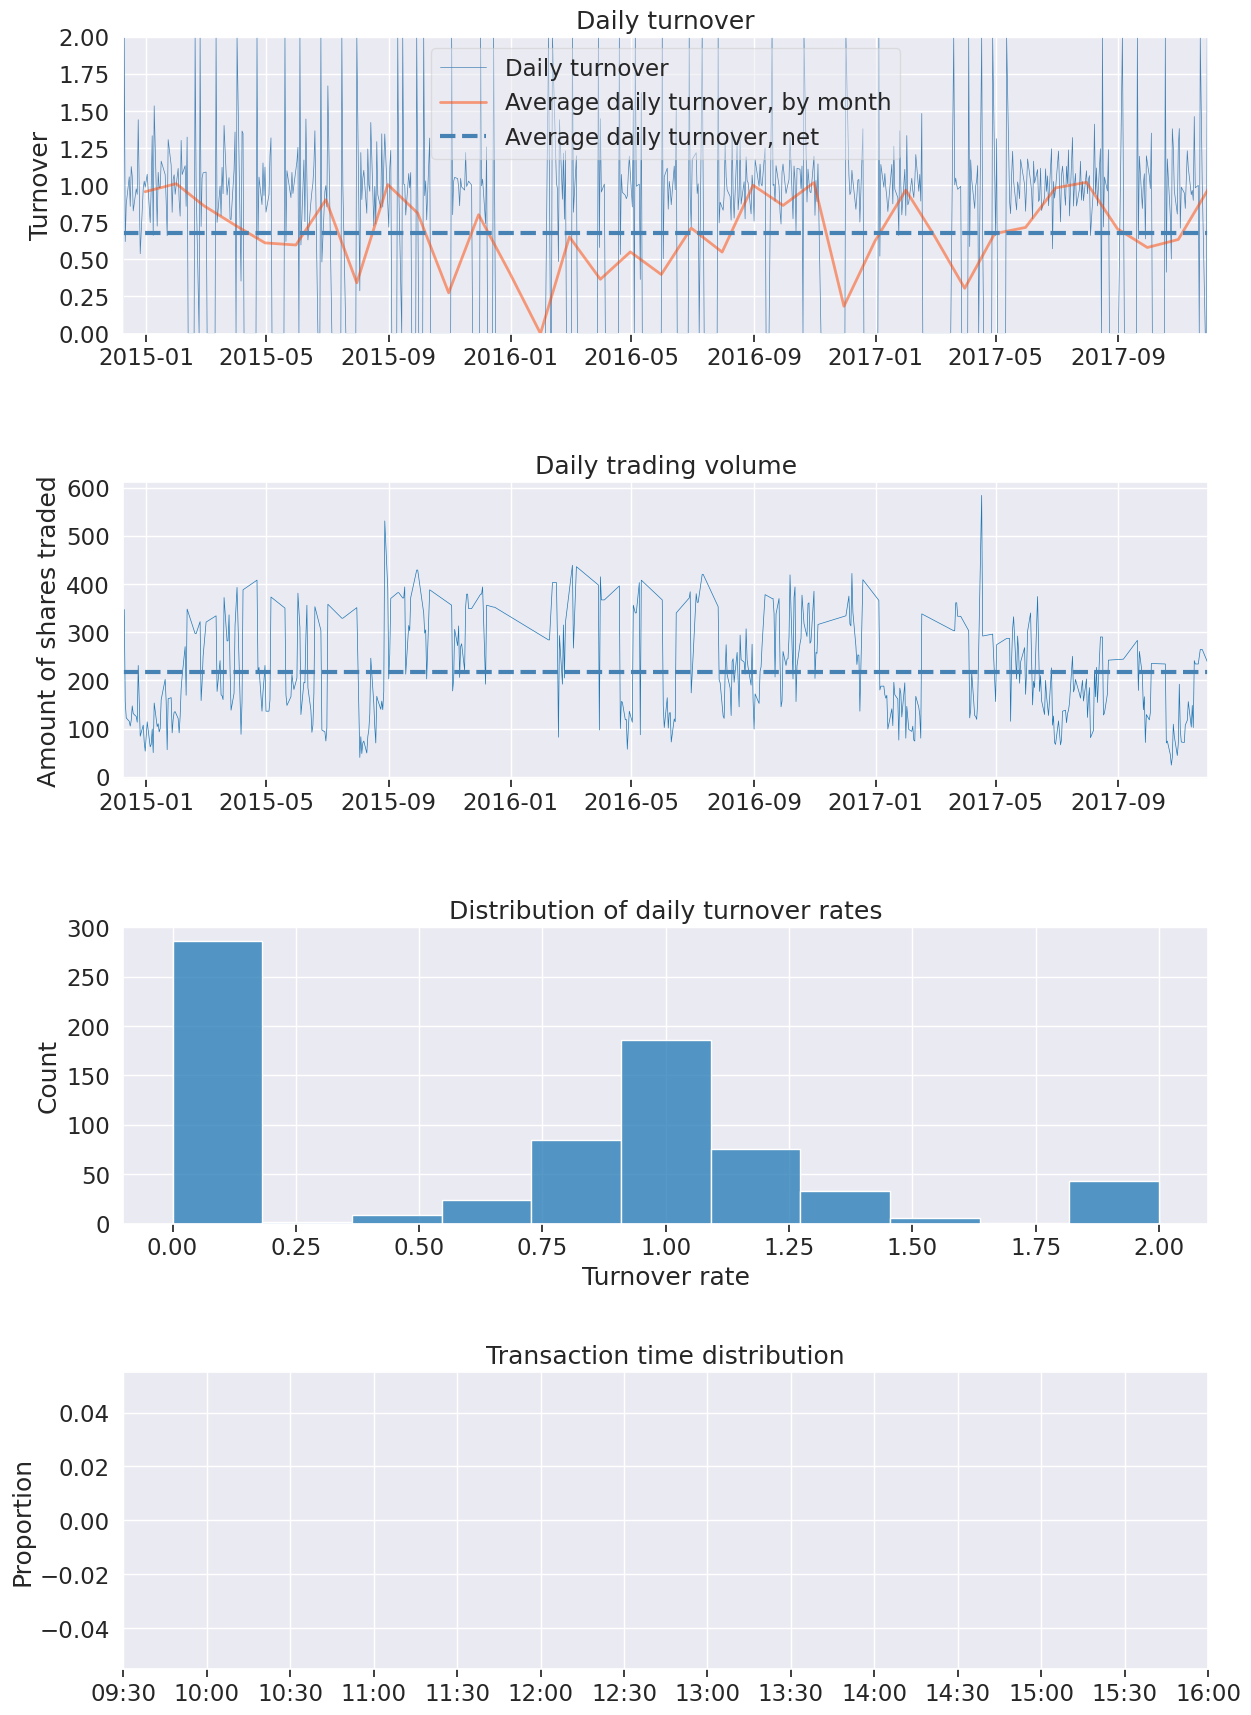

In [81]:
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark.dropna())